In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_score,
    recall_score,
    f1_score,
    make_scorer
)

from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from wordcloud import WordCloud
import re
import string

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("priyangshumukherjee/mental-health-text-classification-dataset")

print("Path to dataset files:", path)
print(os.listdir(path))

Using Colab cache for faster access to the 'mental-health-text-classification-dataset' dataset.
Path to dataset files: /kaggle/input/mental-health-text-classification-dataset
['mental_health_combined_test.csv', 'mental_heath_unbanlanced.csv', 'mental_heath_feature_engineered.csv']


### load data

In [3]:
df = pd.read_csv(path + '/mental_heath_unbanlanced.csv')
df.head()

,Unique_ID,text,status
0,0.0,oh my gosh,Anxiety
1,1.0,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2.0,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3.0,I've shifted my focus to something else but I'...,Anxiety
4,4.0,"I'm restless and restless, it's been a month n...",Anxiety


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49612 entries, 0 to 49611
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Unique_ID  40012 non-null  float64
 1   text       49612 non-null  object 
 2   status     49612 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [5]:
df.isna().sum()

,0
Unique_ID,9600
text,0
status,0


drop unique ID

In [6]:
df = df.drop(columns=['Unique_ID'])

In [7]:
df['text_length'] = df['text'].apply(lambda x: len(x.split(' ')))
df.head()

,text,status,text_length
0,oh my gosh,Anxiety,3
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14
3,I've shifted my focus to something else but I'...,Anxiety,11
4,"I'm restless and restless, it's been a month n...",Anxiety,14


### EDA

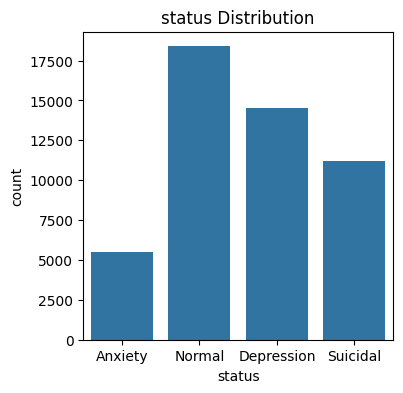

,count
status,
Normal,18391
Depression,14506
Suicidal,11212
Anxiety,5503


In [8]:
plt.figure(figsize=(4,4))
sns.countplot(x='status', data=df)
plt.title('status Distribution')
plt.show()

df.status.value_counts()

wordcloud

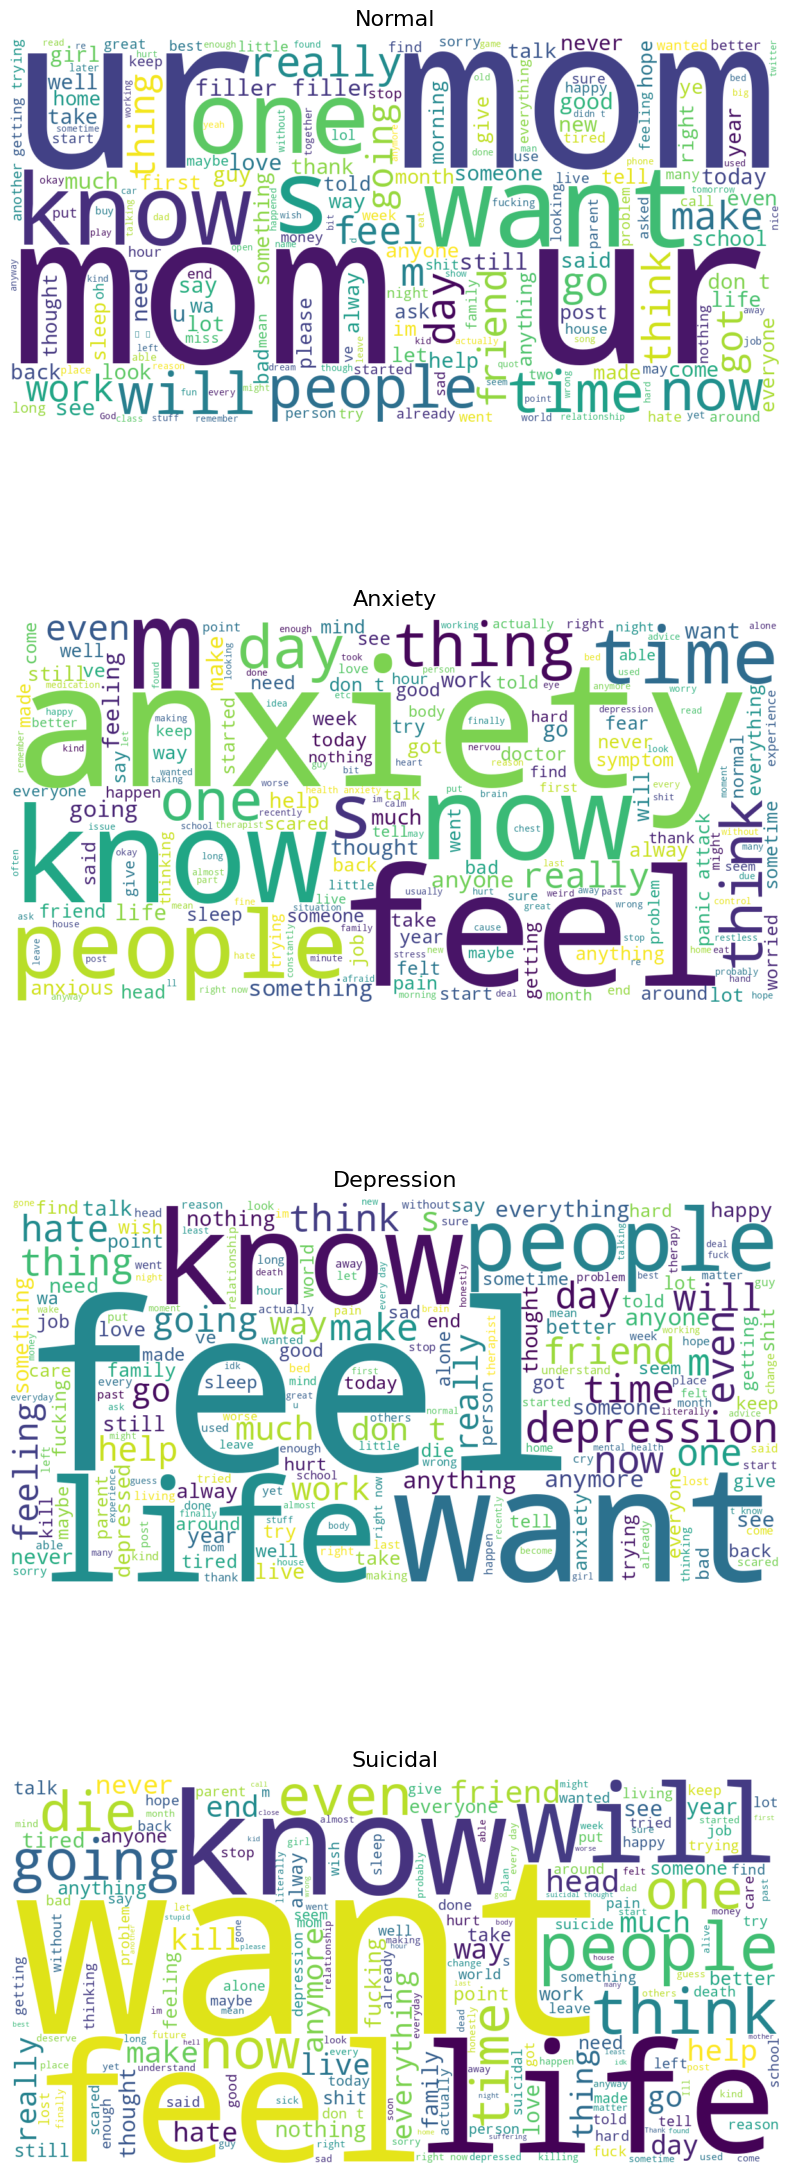

In [9]:
status = [
    'Normal',
    'Anxiety',
    'Depression',
    'Suicidal'
    ]

plt.figure(figsize=(8, 24))

for i, s in enumerate(status):
    plt.subplot(4, 1, i + 1)

    subset_data = df[df['status'] == s]['text']
    text_combined = ' '.join(subset_data.astype(str).tolist())

    wc = WordCloud(
        background_color='white',
        width=1200,
        height=600,
    ).generate(text_combined)

    plt.imshow(wc, interpolation='bilinear')
    plt.title(s, fontdict={'size': 16, 'verticalalignment': 'bottom'})
    plt.axis("off")

plt.tight_layout()
plt.show()

### prepocessing

cleaning text minimal

In [10]:
def clean_text(text):
  text = text.lower()
  text = re.sub(f"[{string.punctuation}]", "", text)
  return text

In [11]:
df['text_clean'] = df['text'].apply(lambda x: clean_text(x))

encode status 0 - 3

In [12]:
le = LabelEncoder()
le.fit(df['status'])

df['status'] = le.transform(df['status'])
df.head()

,text,status,text_length,text_clean
0,oh my gosh,0,3,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",0,10,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",0,14,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,0,11,ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",0,14,im restless and restless its been a month now ...


### modelling

In [13]:
X = df['text_clean']
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y)

#### countvector

In [14]:
vect  = CountVectorizer()
X_train_vect = vect.fit_transform(X_train)
X_test_vect  = vect.transform(X_test)

In [15]:
multi = Pipeline([
    ('vectorizer', CountVectorizer(min_df=2)),
    ('classifier', MultinomialNB(alpha=1.0))
])

bernoulli = Pipeline([
    ('vectorizer', CountVectorizer(binary=True, min_df=2)),
    ('classifier', BernoulliNB(alpha=1.0))
])

In [16]:
scoring = {
    'precision':  make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0)
}

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

results = {}

for name, model in zip(
    ['multi', 'bernoulli'],
    [multi, bernoulli]
):
    cv_results = cross_validate(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring
    )

    results[(name, 'Score')] = {
        'Precision':  cv_results['test_precision'].mean(),
        'Recall': cv_results['test_recall'].mean(),
        'F1-Score': cv_results['test_f1'].mean()
    }

    results[(name, 'Mean ± Std')] = {
        'Precision':  f"{cv_results['test_precision'].mean():.4f} ± {cv_results['test_precision'].std():.4f}",
        'Recall': f"{cv_results['test_recall'].mean():.4f} ± {cv_results['test_recall'].std():.4f}",
        'F1-Score': f"{cv_results['test_f1'].mean():.4f} ± {cv_results['test_f1'].std():.4f}"
    }

In [17]:
results_df = pd.DataFrame(results).T
print("multinomial vs bernoulli (countvectorizer)")
print(f"\n{results_df}")

multinomial vs bernoulli (countvectorizer)

                            Precision           Recall         F1-Score
multi     Score              0.740877          0.72801         0.731972
          Mean ± Std  0.7409 ± 0.0055  0.7280 ± 0.0059  0.7320 ± 0.0057
bernoulli Score               0.66833         0.671672         0.660838
          Mean ± Std  0.6683 ± 0.0038  0.6717 ± 0.0029  0.6608 ± 0.0033


##### multinomialNB

In [18]:
cr = classification_report(
    y_test,
    multi.fit(X_train, y_train).predict(X_test),
    output_dict=True
)

pd.DataFrame(cr).T

,precision,recall,f1-score,support
0,0.699248,0.760218,0.728460,1101.000000
1,0.628306,0.630472,0.629387,2901.000000
2,0.915480,0.803970,0.856109,3678.000000
3,0.628240,0.724030,0.672742,2243.000000
accuracy,0.730323,0.730323,0.730323,0.730323
macro avg,0.717819,0.729673,0.721675,9923.000000
weighted avg,0.742605,0.730323,0.734215,9923.000000


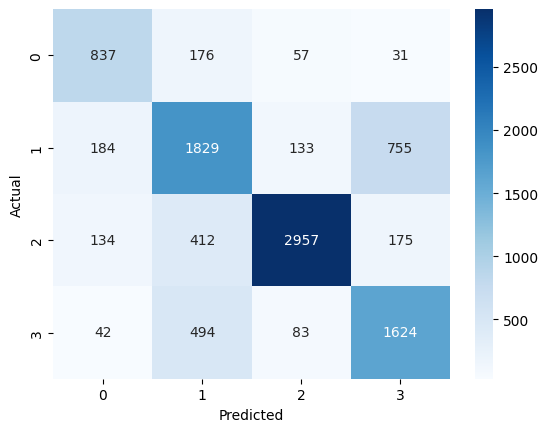

In [19]:
cm = confusion_matrix(y_test, multi.fit(X_train, y_train).predict(X_test))

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##### bernoulliNB

In [20]:
cr = classification_report(
    y_test,
    bernoulli.fit(X_train, y_train).predict(X_test),
    output_dict=True
)

pd.DataFrame(cr).T

,precision,recall,f1-score,support
0,0.634170,0.596730,0.614881,1101.000000
1,0.667558,0.516374,0.582313,2901.000000
2,0.696058,0.912181,0.789598,3678.000000
3,0.637411,0.518056,0.571569,2243.000000
accuracy,0.672377,0.672377,0.672377,0.672377
macro avg,0.658799,0.635835,0.639590,9923.000000
weighted avg,0.667603,0.672377,0.660329,9923.000000


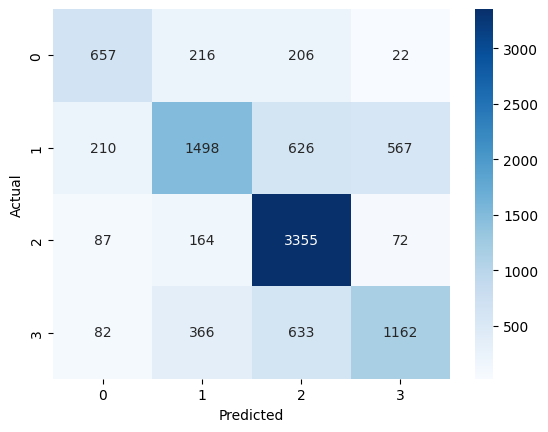

In [21]:
cm = confusion_matrix(y_test, bernoulli.fit(X_train, y_train).predict(X_test))

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### TFIDF

In [22]:
tfidf  = TfidfVectorizer(
    min_df=2,
    max_features=1000,
    ngram_range=(1, 2)
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

In [23]:
multi_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(
        min_df=2,
        max_features=1000,
        ngram_range=(1, 2)
    )),
    ('classifier', MultinomialNB(alpha=1.0))
])

bernoulli_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(
        min_df=2,
        max_features=1000,
        ngram_range=(1, 2)
    )),
    ('classifier', BernoulliNB(alpha=1.0))
])

In [24]:
scoring = {
    'precision':  make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0)
}

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

results_tfidf = {}

for name, model in zip(
    ['multi_tfidf', 'bernoulli_tfidf'],
    [multi_tfidf, bernoulli_tfidf]
):
    cv_results = cross_validate(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring
    )

    results_tfidf[(name, 'Score')] = {
        'Precision':  cv_results['test_precision'].mean(),
        'Recall': cv_results['test_recall'].mean(),
        'F1-Score': cv_results['test_f1'].mean()
    }

    results_tfidf[(name, 'Mean ± Std')] = {
        'Precision':  f"{cv_results['test_precision'].mean():.4f} ± {cv_results['test_precision'].std():.4f}",
        'Recall': f"{cv_results['test_recall'].mean():.4f} ± {cv_results['test_recall'].std():.4f}",
        'F1-Score': f"{cv_results['test_f1'].mean():.4f} ± {cv_results['test_f1'].std():.4f}"
    }

In [25]:
results_tfidf_df = pd.DataFrame(results_tfidf).T
print("multinomial vs bernoulli (tfidf)")
print(f"\n{results_tfidf_df}")

multinomial vs bernoulli (tfidf)

                                  Precision           Recall         F1-Score
multi_tfidf     Score              0.700836          0.69193         0.683005
                Mean ± Std  0.7008 ± 0.0051  0.6919 ± 0.0050  0.6830 ± 0.0053
bernoulli_tfidf Score               0.66779         0.666935         0.654208
                Mean ± Std  0.6678 ± 0.0034  0.6669 ± 0.0029  0.6542 ± 0.0034


##### multinomialNB

In [26]:
cr = classification_report(
    y_test,
    multi_tfidf.fit(X_train, y_train).predict(X_test),
    output_dict=True
)

pd.DataFrame(cr).T

,precision,recall,f1-score,support
0,0.850554,0.418710,0.561169,1101.000000
1,0.580071,0.674250,0.623625,2901.000000
2,0.760261,0.886351,0.818479,3678.000000
3,0.675189,0.518056,0.586276,2243.000000
accuracy,0.689207,0.689207,0.689207,0.689207
macro avg,0.716519,0.624342,0.647387,9923.000000
weighted avg,0.698371,0.689207,0.680476,9923.000000


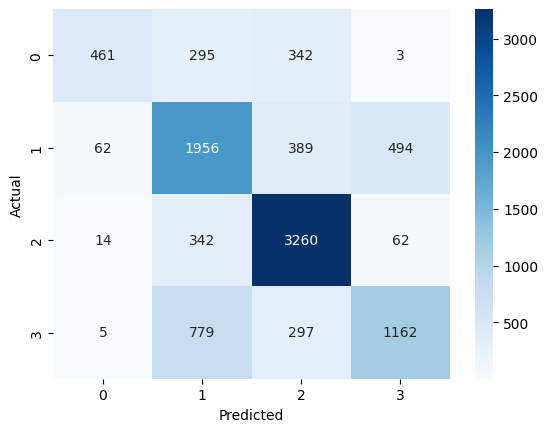

In [27]:
cm = confusion_matrix(y_test, multi_tfidf.fit(X_train, y_train).predict(X_test))

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##### bernoulliNB

In [28]:
cr = classification_report(
    y_test,
    bernoulli_tfidf.fit(X_train, y_train).predict(X_test),
    output_dict=True
)

pd.DataFrame(cr).T

,precision,recall,f1-score,support
0,0.556515,0.702089,0.620884,1101.000000
1,0.693382,0.462254,0.554705,2901.000000
2,0.712285,0.912724,0.800143,3678.000000
3,0.630101,0.530094,0.575787,2243.000000
accuracy,0.671168,0.671168,0.671168,0.671168
macro avg,0.648071,0.651790,0.637880,9923.000000
weighted avg,0.670898,0.671168,0.657786,9923.000000


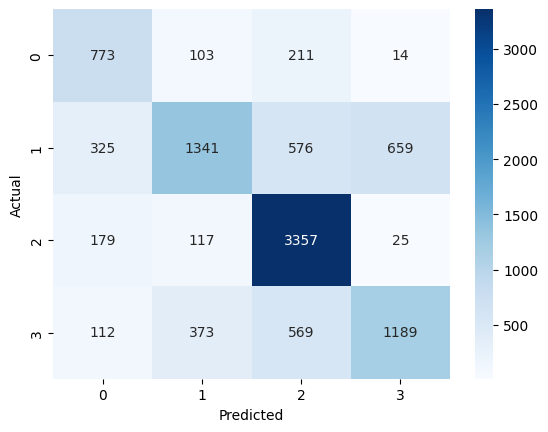

In [29]:
cm = confusion_matrix(y_test, bernoulli_tfidf.fit(X_train, y_train).predict(X_test))

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()